In [15]:
Path().resolve()

PosixPath('/home/srirama/sr_proj/ECGHeartbeatCategorization/notebooks/2-lstm-tflite')

In [14]:
BASE_DIR

PosixPath('/home/srirama/sr_proj/ECGHeartbeatCategorization')

In [17]:
import sys
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('dark_background')
print(sys.version)
print("Numpy version :",np.__version__)
print("Pandas version :",pd.__version__)
print("Matplotlib version :",matplotlib.__version__)
print("Seaborn version :",sns.__version__)

NOTEBOOK_DIR = Path().resolve()
NOTEBOOK_NAME = Path().resolve().name
BASE_DIR = NOTEBOOK_DIR.parents[1]

DATASET_DIR = BASE_DIR / "data"/ "1"
MODELS_DIR = NOTEBOOK_DIR / "models"
MODELS_DIR.mkdir(exist_ok=True)
print("Models will be saved to:", MODELS_DIR)

TRAIN_FILE_PATH = DATASET_DIR / "mitbih_train.csv"
TEST_FILE_PATH = DATASET_DIR / "mitbih_test.csv"
print("Base directory of this project : ",BASE_DIR)
print("Train Dataset :",TRAIN_FILE_PATH)
print(f"Importing Helper from : {BASE_DIR}")
sys.path.append(str(BASE_DIR))
import helper

3.12.3 (main, Jan  8 2026, 11:30:50) [GCC 13.3.0]
Numpy version : 2.3.5
Pandas version : 2.3.3
Matplotlib version : 3.10.0
Seaborn version : 0.13.2
Models will be saved to: /home/srirama/sr_proj/ECGHeartbeatCategorization/notebooks/2-lstm-tflite/models
Base directory of this project :  /home/srirama/sr_proj/ECGHeartbeatCategorization
Train Dataset : /home/srirama/sr_proj/ECGHeartbeatCategorization/data/1/mitbih_train.csv
Importing Helper from : /home/srirama/sr_proj/ECGHeartbeatCategorization


In [8]:
MLFLOW_ENABLED = True
if MLFLOW_ENABLED:
    import mlflow
    from mlflow.tensorflow import autolog
    experiment_name = NOTEBOOK_NAME
    tracking_uri = "http://localhost:5000/"
    run_number = helper.get_next_run_number(experiment_name, tracking_uri)
    run_name = "run" + str(run_number)
    mlflow.set_tracking_uri(tracking_uri)
    mlflow.set_experiment(experiment_name)
    mlflow.start_run(run_name=run_name,log_system_metrics=True)
    autolog(log_models=True, log_input_examples=True, log_model_signatures=True)
    print(f"MLflow run started | experiment={experiment_name} | run_name={run_name}")

2026-01-22 04:36:36.755144: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/srirama/sr_proj/tf-venv/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):
2026/01/22 04:36:41 INFO mlflow.tracking.fluent: Experiment with name '2-lstm-tflite' does not exist. Creating a new experiment.
2026/01/22 04:36:41 INFO mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics. Set logger level to DEBUG for more details.
2026/01/22 04:36:41 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


MLflow run started | experiment=2-lstm-tflite | run_name=run1


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPool1D, Flatten, Dense, Dropout, BatchNormalization,Input,MaxPooling1D,GlobalAveragePooling1D
from tensorflow.keras.utils import to_categorical
print("Tensorflow version :",tf.__version__)
print("Avaiable devices :",tf.config.get_visible_devices())

Tensorflow version : 2.20.0
Avaiable devices : [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [18]:
# Load Data
from IPython.display import display
train_df = pd.read_csv(TRAIN_FILE_PATH, header=None)
test_df = pd.read_csv(TEST_FILE_PATH, header=None)
display(train_df.sample(3))
display(test_df.sample(3))

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
82919,0.824324,0.513514,0.489865,0.476351,0.452703,0.412162,0.375000,0.300676,0.243243,0.108108,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
13924,1.000000,0.974811,0.783375,0.360202,0.267003,0.317380,0.352645,0.350126,0.312343,0.312343,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8237,0.877470,0.873518,0.387352,0.000000,0.191041,0.218709,0.169960,0.169960,0.169960,0.164690,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
14148,1.000000,0.835391,0.534979,0.349794,0.333333,0.279835,0.220165,0.183128,0.150206,0.121399,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17241,0.758197,0.176230,0.000000,0.241803,0.344262,0.368852,0.405738,0.418033,0.405738,0.405738,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14226,1.000000,0.874552,0.390681,0.189964,0.093190,0.093190,0.039427,0.043011,0.007168,0.017921,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
# Separate features (X) and labels (y)
X_train_raw = train_df.iloc[:, :-1].values
y_train_raw = train_df.iloc[:, -1].values
X_test_raw = test_df.iloc[:, :-1].values
y_test_raw = test_df.iloc[:, -1].values

In [20]:
# Preprocessing
NUM_CLASSES = 5 
CLASS_NAMES = ['N (0) - Normal', 'S (1) - SVEB', 'V (2) - VEB', 'F (3) - Fusion', 'Q (4) - Unknown']
INPUT_LENGTH  = X_train_raw.shape[1]
# One-Hot Encode Output Labels (Needed for categorical_crossentropy)
y_train_cat = to_categorical(y_train_raw, num_classes=NUM_CLASSES)
y_test_cat = to_categorical(y_test_raw, num_classes=NUM_CLASSES)

In [13]:
print(f"Original Training data shape: {X_train_raw.shape}")
print(f"Class distribution before balancing:\n{train_df.iloc[:, -1].value_counts(normalize=True).sort_index()}")
print(f"Number of sensor inputs : {INPUT_LENGTH} and Output Categories : {NUM_CLASSES}")

Original Training data shape: (87554, 187)
Class distribution before balancing:
187
0.0    0.827729
1.0    0.025390
2.0    0.066108
3.0    0.007321
4.0    0.073452
Name: proportion, dtype: float64
Number of sensor inputs : 187 and Output Categories : 5


In [16]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train_raw),
    y=y_train_raw
)
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: np.float64(0.24162492583240192), 1: np.float64(7.877103013945119), 2: np.float64(3.0253628196268143), 3: np.float64(27.317940717628705), 4: np.float64(2.7228735810915876)}


In [17]:
from sklearn.model_selection import train_test_split
# Split training data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(
    X_train_raw, y_train_cat, test_size=0.2, random_state=42, stratify=y_train_cat) 

Because Conv1D expects:
- A sequence = 187 timesteps
- A channel per timestep = 1 feature per time instant
If you had multi-channel signals (like accelerometers with x/y/z axes), it would be (187, 3).

In [18]:
# Reshape for Conv1D: (batch, timesteps, channels)
X_train = X_train.reshape(-1, INPUT_LENGTH, 1)
X_test  = X_test.reshape(-1, INPUT_LENGTH, 1)
print(X_train.shape)   # (?, 187, 1)
print(y_train.shape)   # (?, 5)

(70043, 187, 1)
(70043, 5)


In [19]:
model_baseline = Sequential([
    Input(shape=(INPUT_LENGTH, 1)),

    Conv1D(8, kernel_size=5, activation="relu", padding="same"),
    MaxPooling1D(pool_size=2),

    Conv1D(16, kernel_size=5, activation="relu", padding="same"),
    MaxPooling1D(pool_size=2),

    Conv1D(32, kernel_size=3, activation="relu", padding="same"),
    GlobalAveragePooling1D(),

    Dense(16, activation="relu"),
    Dropout(0.3),

    Dense(NUM_CLASSES, activation="softmax")
])
model_baseline.summary()
model_baseline.compile(optimizer='adam', 
                       loss='categorical_crossentropy', 
                       metrics=['accuracy']) 

I0000 00:00:1766766906.053644   21129 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1767 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2050, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 187, 8)         │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 93, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 93, 16)         │           656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 46, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 46, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,885 (11.27 KB)

 Trainable params: 2,885 (11.27 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
]
print("--- Starting Baseline Model Training (Imbalanced Data) ---")
history_baseline = model_baseline.fit(
    X_train, y_train, 
    epochs=70, 
    batch_size=256, 
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    class_weight=class_weights
)

--- Starting Baseline Model Training (Imbalanced Data) ---
Epoch 1/70
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5595 - loss: 0.7518 - val_accuracy: 0.5746 - val_loss: 0.8447
Epoch 2/70
274/274 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.5754 - loss: 0.7420 - val_accuracy: 0.6181 - val_loss: 0.8589
Epoch 3/70
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5784 - loss: 0.7358 - val_accuracy: 0.5925 - val_loss: 0.8539
Epoch 4/70
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5819 - loss: 0.7361 - val_accuracy: 0.5591 - val_loss: 0.9226
Epoch 5/70
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5739 - loss: 0.7134 - val_accuracy: 0.6586 - val_loss: 0.8314
Epoch 6/70
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5922 - loss: 0.7207 - val_accuracy: 0.6194 - val_loss: 0.8921
Epoch 7/70
274/274 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6020 - loss: 0.7083 - val_accuracy: 0.5583 - val_loss: 0.9619
Epoch 8/70
274/274 ━━━━━━━━━━━━━━━━━━━━ 

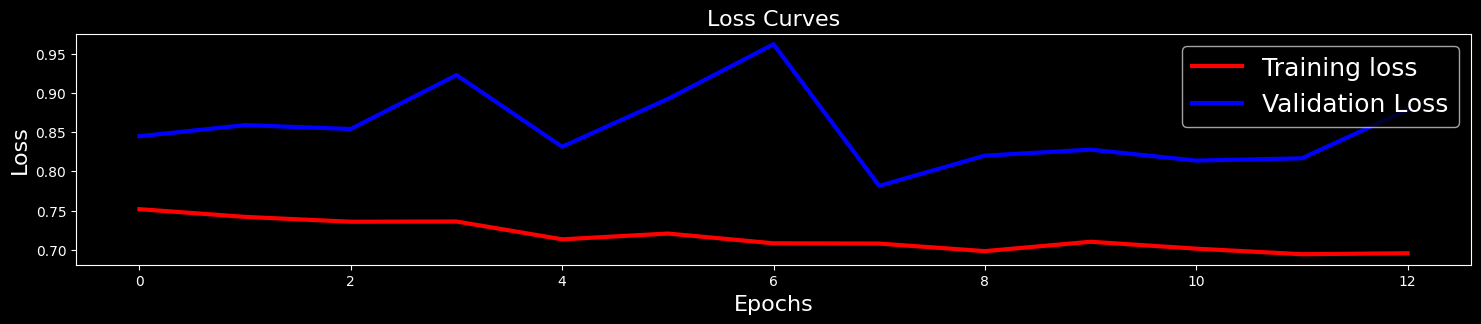

In [22]:
plt.figure(figsize=[18,3])
plt.plot(history_baseline.history['loss'], 'r', linewidth=3.0, label='Training loss')
plt.plot(history_baseline.history['val_loss'], 'b', linewidth=3.0, label='Validation Loss')
plt.legend(fontsize=18)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Loss Curves', fontsize=16)
plt.show()

In [39]:
model_baseline.save_weights(CURRENT_MODEL_DIR / 'baseline_model.weights.h5') 
model_baseline.export(CURRENT_MODEL_DIR / "baseline_model")

INFO:tensorflow:Assets written to: /home/srirama/sr_proj/ECGHeartbeatCategorization/notebooks/models/2-1dcnn-tflite.ipynb/baseline_model/assets


INFO:tensorflow:Assets written to: /home/srirama/sr_proj/ECGHeartbeatCategorization/notebooks/models/2-1dcnn-tflite.ipynb/baseline_model/assets


Saved artifact at '/home/srirama/sr_proj/ECGHeartbeatCategorization/notebooks/models/2-1dcnn-tflite.ipynb/baseline_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 187, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  125894706931728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125894706932496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125894706932112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125894706934416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125894706933648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125894706935376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125894706934800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125894706934992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125894706934032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1258

In [ ]:
# Convert Keras model to TF Lite format.
converter = tf.lite.TFLiteConverter.from_keras_model(model_baseline)
tflite_float_model = converter.convert()
# Show model size in KBs.
float_model_size = len(tflite_float_model) / 1024

INFO:tensorflow:Assets written to: /tmp/tmpfl22btzg/assets


INFO:tensorflow:Assets written to: /tmp/tmpfl22btzg/assets


Saved artifact at '/tmp/tmpfl22btzg'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 187, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  125894706931728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125894706932496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125894706932112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125894706934416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125894706933648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125894706935376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125894706934800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125894706934992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125894706934032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125894706935184: TensorSpec(shape=(), dtype=tf.resource, name=None)
Float model size = 17

W0000 00:00:1766769405.537312   21129 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1766769405.537412   21129 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-12-26 17:16:45.538202: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpfl22btzg
2025-12-26 17:16:45.539365: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-12-26 17:16:45.539397: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpfl22btzg
I0000 00:00:1766769405.549055   21129 mlir_graph_optimization_pass.cc:437] MLIR V1 optimization pass is not enabled
2025-12-26 17:16:45.550400: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-12-26 17:16:45.600961: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpfl22btzg
2025-12-26 17:16:45.617692: I tensorflow/cc/saved_model/loader.cc:471] SavedModel 

In [26]:
print('Float model size = %dKBs.' % float_model_size)

Float model size = 17KBs.


In [ ]:
# Re-convert the model to TF Lite using quantization.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()
# Show model size in KBs.
quantized_model_size = len(tflite_quantized_model) / 1024

INFO:tensorflow:Assets written to: /tmp/tmpirdcdlaf/assets


INFO:tensorflow:Assets written to: /tmp/tmpirdcdlaf/assets


Saved artifact at '/tmp/tmpirdcdlaf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 187, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  125894706931728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125894706932496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125894706932112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125894706934416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125894706933648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125894706935376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125894706934800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125894706934992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125894706934032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  125894706935184: TensorSpec(shape=(), dtype=tf.resource, name=None)
Quantized model size 

W0000 00:00:1766769442.168490   21129 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1766769442.168601   21129 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-12-26 17:17:22.168846: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpirdcdlaf
2025-12-26 17:17:22.169714: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-12-26 17:17:22.169726: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpirdcdlaf
2025-12-26 17:17:22.177962: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-12-26 17:17:22.221385: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpirdcdlaf
2025-12-26 17:17:22.235151: I tensorflow/cc/saved_model/loader.cc:471] SavedModel load for tags { serve }; Status: success: OK. Took 66309 microseconds.


In [ ]:
print('Quantized model size = %dKBs,' % quantized_model_size)
print('which is about %d%% of the float model size.'% (quantized_model_size * 100 / float_model_size))

Quantized model size = 13KBs,
which is about 76% of the float model size.


In [30]:
# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_tflite_model(tflite_model,X_test,y_test_raw,input_length=187):
    """Evaluate a TF Lite model for Conv1D ECG classification"""

    # Initialize interpreter
    interpreter = tf.lite.Interpreter(model_content=tflite_model)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    input_index = input_details[0]["index"]
    output_index = output_details[0]["index"]

    correct = 0

    for i in range(len(X_test)):
        # Prepare input: (1, 187, 1)
        sample = X_test[i].reshape(1, input_length, 1).astype(np.float32)

        interpreter.set_tensor(input_index, sample)
        interpreter.invoke()

        # Get prediction
        output = interpreter.get_tensor(output_index)
        pred_class = np.argmax(output[0])
        true_class = y_test_raw[i]

        if pred_class == true_class:
            correct += 1

    accuracy = correct / len(X_test)
    return accuracy


float_accuracy = evaluate_tflite_model(tflite_float_model,X_test,y_test_raw,input_length=INPUT_LENGTH)
print(f"Float TFLite model accuracy = {float_accuracy:.4f}")

quantized_accuracy = evaluate_tflite_model(tflite_quantized_model,X_test,y_test_raw,input_length=INPUT_LENGTH)
print(f"Quantized TFLite model accuracy = {quantized_accuracy:.4f}")
print(f"Accuracy drop = {float_accuracy - quantized_accuracy:.4f}")


Float TFLite model accuracy = 0.5545
Quantized TFLite model accuracy = 0.5464
Accuracy drop = 0.0081


In [40]:
# Save the quantized model to file to the Downloads directory
f = open(str(CURRENT_MODEL_DIR / '1dcnn.tflite'), "wb")
f.write(tflite_quantized_model)
f.close()
print('`1dcnn.tflite` has been downloaded')

`1dcnn.tflite` has been downloaded


In [ ]:
# https://onnxruntime.ai/docs/tutorials/tf-get-started.html - I am getting protobuf error (but still works)
# Error is tf-2.20 needs protobuf>=5.28.0 (I had 6.33.2)
# But tf2onnx needs protobuf needs 3.20.3
import tf2onnx
import onnx
import tensorflow as tf
print("Tf2onnx version :",tf2onnx.__version__)
model_baseline.output_names = ['output']
spec = [tf.TensorSpec([None, INPUT_LENGTH, 1], tf.float32, name="input")]
output_path = str(CURRENT_MODEL_DIR / "baseline_model.onnx")

onnx_model, _ = tf2onnx.convert.from_keras(
    model_baseline,
    input_signature=spec,
    opset=13
)
onnx.save(onnx_model , output_path)
print("Saved ONNX model to:", output_path)


In [21]:
if MLFLOW_ENABLED:
    mlflow.end_run()
    print(f"MLflow run completed | run_name={run_name}")

2026/01/22 04:50:02 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2026/01/22 04:50:02 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


🏃 View run run1 at: http://localhost:5000/#/experiments/1/runs/5a132084a4e54a5580eec5b90e6122c9
🧪 View experiment at: http://localhost:5000/#/experiments/1
MLflow run completed | run_name=run1
